# Static exploration tool for assessment schemes in ICNIRP 2020 and RPS S-1
author: Dr Vitas Anderson (*Two Fields Consulting*)

date: 9/9/2021

To use this Jupyter notebook, run each code cell in succession by either pressing the triangular Run button ► in the menu bar above or by pressing SHIFT-ENTER for successive code cells. You can play around with the code as much as you like - it won't affect the original notebook.

The notebook contains a function, `calc_ass`, which calculates limit-normalised exposure assessments from two RF sources for the following assessment schemes:

+ **Lwbps**: whole body point spatial (the scheme which is currently used for EME calcuated assessments)
+ **Llocps**: local point spatial
+ **Lwbsa**: whole body spatial average (as now required for whole body exposure to E/H/S in ICNIRP 2020 and RPS S-1)
+ **Lwbpssa**: a point spatial representation of the whole body spatial average

The assessments are conducted on artificial RF limit-normalised power density exposure distributions using the following formula:

$\Large L_{wbps} = \frac{k_1}{\textrm{cosh}(k_2(z-z_{source}))}$

where:

+ $z$ is the height of the evaluation point
+ $z_{source}$ is the height of the RF source
+ $k_1$ is a parameter to vary the level of the source field
+ $k_2$ is a parameter to vary the vertical beam width of the source

## Import python modules

In [2]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from collections import namedtuple
from collections.abc import Iterable
pd.options.display.max_rows = 201
np.set_printoptions(precision=4)

## Functions

In [3]:
def make_list(obj):
    '''make sure obj is a list'''
    if isinstance(obj, Iterable):
        return list(obj)
    else:
        return [obj]    

def check_source_inputs(*sources, n=None):
    '''Make sure that all source inputs are lists which are of the same length
       and are of length n if n is specified'''
    sources = [make_list(source) for source in sources]
    len_sources = [len(source) for source in sources]
    errmsg = f'All source inputs {sources} must have the same number of elements'
    assert len(set(len_sources)) == 1, errmsg
    if n != None:
        errmsg = f'All k1s, k2s, zs source inputs {sources} must each have {n} elements'
        assert len_sources[0] == n, errmsg
    
    return sources

def check_dz(dz,h,zlow,zhigh):
    '''Check that dz is a valid input'''
    # check that the z range is divisible by dz
    zrange = zhigh - zlow
    nz = int(zrange/dz)   # number of dz intervals in z range
    assert nz == zrange/dz, f"z range ({zrange}) must be divisible by dz ({dz})"
    
    # check that spatial average window length is divisible by dz
    nh = int(h/dz)    # number of dz intervals within spatial averaging window    
    nh2 = int(nh/2)   # number of dz intervals between the centre and the end of the spatial averaging window
    assert nh == h/dz, f"h ({h}) must be divisible by dz ({dz})"  

    return nz, nh, nh2
    
def calc_z(zlow, zhigh, nz):
    '''Calculate the z distribution'''
    z = np.linspace(zlow, zhigh, nz+1)
    return z

def calc_Lwbps(k1s,k2s,zs,z,nz):
    '''Calculate the whole body point spatial distribution for limit normalised exposure (Lwbps)'''
    Lwbps = np.zeros(nz+1)                  # initialise Lwbps array with zeros
    for k1i, k2i, zi in zip(k1s, k2s, zs):  # loop through each source
        Lwbps += k1i / np.cosh(k2i*(z-zi))    # add limit normalized field level for each source
    return Lwbps

def calc_Llocps(Lwbps, fMHz):
    '''Calculate the local point spatial distribution for limit normalised exposure (Llocps)'''
    # Calculate the local limit multiplier factor
    if fMHz <= 400:
        m = 5
    elif fMHz < 2000:
        m = 11.47459891 * fMHz**-0.138646884
    else:
        m = 4
        
    # Calculate and return Llocps
    return Lwbps / m

def calc_valid_nsap(nh, n=None):
    '''Return list of no more than n valid numbers of spatial averaging points
       for any value of nh, the number of dz intervals in h
       If n = None, then show all valid numbers of spatial averaging points'''
    valid_nsap = [i+1 for i in range(1, nh+1) if (nh % i == 0)]
    if (n != None) and (len(valid_nsap) > n):
        valid_nsap = valid_nsap[:n]
    return valid_nsap

def calc_hindices(nh, nh2, nsap):
    '''Determine the array indices of the spatial averaging points
       relative to the assessment point'''
    dh = int(nh / (nsap-1))  # number of indices between spatial averaging points
    hindices = [-nh2 + i*dh for i in range(nsap)]
    hindices = np.array(hindices, dtype=int)  # convert list to numpy integer array
    return hindices

def calc_Lwbsa(Lwbps, nz, nh2, hindices):
    '''Calculate the whole body spatial average distribution (Lwbsa)'''   
    # initialise Lwbsa array with NaN's (Not a Number)
    Lwbsa = np.repeat(np.nan, nz+1)
    
    # calculate the mean value of Lwbps at the spatial averaging points
    for iz in range(nh2, nz-nh2+1):
        Lwbsa[iz] = Lwbps[hindices + iz].mean()
        
    return Lwbsa
    
def calc_Lwbpssa(Lwbsa, nz, nh, nh2):
    '''Calculate the point spatial representation of the wb spatial average (Lwbpssa)
    INPUTS:
       Lwbsa = spatial average of the whole body limit normalised point spatial field over a vertical line
       nz = number of dz intervals in the z range
       nh = number of dz intervals in the h averaging window
       nh2 = number of dz intervals in half of the h averaging window
    OUTPUTS:
       Lwbpssa = point spatial respresentation of the spatially averaged field (Lwbsa)
       '''
    # initialise Lwbpssa array with NaN's (Not a Number)
    Lwbpssa = np.repeat(np.nan, nz+1)
    
    # first pass: assign Lwbpssa values based on minimum value of points that
    # are half an averaging window above or below the assessment point
    for iz in range(nh, nz-nh+1):
        Lwbpssa[iz] = Lwbsa[[iz-nh2, iz+nh2]].min() 
    
    # second pass: assign Lwbsa value at the point(s) where Lwbsa peaks,
    # i.e. where spatial averaging window exposure changes between head and feet
    ipeaks, _ = find_peaks(Lwbsa)  # get indices of local peaks of Lwbsa values    
    for iz in ipeaks:
        Lwbpssa[iz] = Lwbsa[iz]
        
    # third pass: assign minimum Lwbsa value for the length of the spatial averaging window
    # where Lwbsa is a minimum
    itroughs, _ = find_peaks(1/Lwbsa)  # get indices of local minimums of Lwbsa values
    for iz in itroughs:
        Lwbpssa[(iz-nh2):(iz+nh2)] = Lwbsa[iz]
        
    return Lwbpssa  

In [4]:
def calc_ass(h,nsap,fMHz,zlow,zhigh,dz,k1s,k2s,zs):
    '''Function which calculates assessment distributions over a set z height range for:
       + point spatial limit normalised field values for whole body exposure (Lwbps)
       + point spatial limit normalised field values for local exposure (Llocps)
       + spatial average of the whole body Lwbps points (Lwbsa) over a vertical line
       + point spatial representation of the whole body spatial averages (Lwbpssa)
       
       FUNCTION INPUTS:       
          h = height of the spatial averaging window (m)
       nsap = number of spatial averaging points [3 or 5]
       fMHz = exposure frequency in MHz
       zlow = lower bound of the z points (m)
      zhigh = upper bound of the z points (m)
        k1s = list of k1 parameters that set the peak level of the Lps distribution, 
              e.g. 2 for a single source or [2,1] for two sources
        k2s = list of k2 parameters that set the vertical beamwidth of the Lps distribution
              e.g. 1 for a single source or [1,2] for two sources
        zs = list of heights (m) for the source(s), 
              e.g. 7 for a single source, or [10,13] for two sources
         
       FUNCTION OUTPUTS:
         a named tuple, L, containing:
           + title: an informative title for the assessment
           + fMHz: exposure frequency in MHz
           + labels: lables for each calculated distribution
           + z: the z distribution points for the assessment
           + zlow: the lower bound of the z distribution
           + zhigh: the upper bound of the z distribution
           + lass: a named tuple for the calculated assessments (Lwbps, Llocps, Lwbsa, Lwbpssa)
           + nh: number of points in teh vertical averaging window
           + df: a pandas dataframe for z and Lwbps, Llocps, Lwbsa, Lwbpssa
      '''     
    
    # Check that all source inputs are lists which are of the same length
    k1s,k2s,zs = check_source_inputs(k1s,k2s,zs)
    
    # Check that the dz value is valid for h and the z range
    nz, nh, nh2 = check_dz(dz,h,zlow,zhigh)
    
    # Check that the nsap input is valid for the number of h points
    valid_nsap = calc_valid_nsap(nh)
    assert nsap in valid_nsap, f'Value of nsap ({nsap}) must be one of {valid_nsap}'
    
    # Calculate the z points
    z = calc_z(zlow,zhigh,nz)
    
    # Calculate the whole body point spatial distribution for limit normalised exposure (Lwbps)
    Lwbps = calc_Lwbps(k1s,k2s,zs,z,nz)
    
    # Calculate the local point spatial distribution for limit normalised exposure (Llocps)
    Llocps = calc_Llocps(Lwbps, fMHz)
    
    # Calculate the whole body spatial average distribution (Lwbsa)
    hindices = calc_hindices(nh, nh2, nsap)
    Lwbsa = calc_Lwbsa(Lwbps, nz, nh2, hindices)
    
    # Calculate the point spatial representation of the wb spatial average (Lwbpssa)
    Lwbpssa = calc_Lwbpssa(Lwbsa, nz, nh, nh2)
            
    ## Create a pandas dataframe of z and all assessment distributions
    df = pd.DataFrame(dict(z=z,Lwbps=Lwbps,Llocps=Llocps,Lwbsa=Lwbsa,Lwbpssa=Lwbpssa))
    
    ## Create labels for the limit normalised assessment distributions
    labels = ['wb point spatial',
              'local point spatial',
              'wb spatial average',
              'wb point spatial spat. avg.']
    
    ## Create a title for the data set
    title = f'{nsap} points over {h}m\n' + '$k_1$' + f'={",".join(map(str,k1s))}, ' + '$k_2$' + f'={",".join(map(str,k2s))}, f={fMHz} MHz'
    
    ## Create a named tuple for all the L assessment distributions
    Lass = namedtuple("Lass", "Lwbps, Llocps, Lwbsa, Lwbpssa")
    lass = Lass(Lwbps, Llocps, Lwbsa, Lwbpssa)
    
    ## Create a named tuple for all the output data
    Ldata = namedtuple("Ldata", "title fMHz labels z zlow zhigh lass nh df")
    ldata = Ldata(title, fMHz, labels, z, zlow, zhigh, lass, nh, df)

    return ldata

def plotL(L):
    '''Plot the L distributions'''
    fig, ax = plt.subplots(figsize=(4,8))
    for lass, label in zip(L.lass, L.labels):
        ax.plot(lass, L.z, alpha=0.6, label=label)
    ax.set_xlabel('Limit normalised field value')
    ax.set_ylabel('z (m)')
    ax.grid(ls='--')
    ax.legend()
    zmin, zmax = int(L.zlow), int(L.zhigh)
    ax.set_yticks(range(zmin,zmax))
    ax.set_ylim(zmin,zmax)
    ax.set_title(L.title)
    fig.tight_layout()
    
    return ax

## Vary $k_1$ and $k_2$ 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
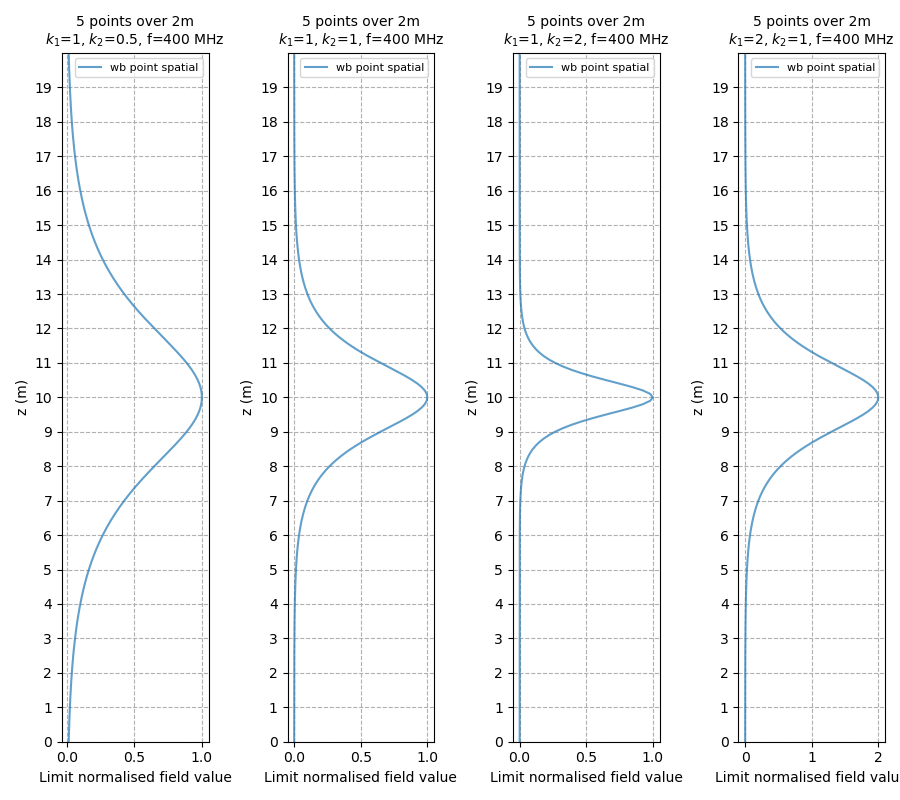

In [5]:
fig, axes = plt.subplots(1,4,figsize=(9,8))
for j, (k1,k2) in enumerate(zip([1,1,1,2],[0.5,1,2,1])):
    
    # Calculate the assesments
    L = calc_ass(h=2, nsap=5, fMHz=400,
                 zlow=0, zhigh=20, dz=0.1,
                 k1s=k1, k2s=k2, zs=10
                )
    
    # Create the plots
    ax = axes[j]
    ax.plot(L.lass.Lwbps, L.z, alpha=0.7, label=L.labels[0])
    ax.set_xlabel('Limit normalised field value')
    ax.set_ylabel('z (m)')
    ax.grid(ls='--')
    ax.legend(fontsize=8,loc='upper right')
    zmin, zmax = int(L.zlow), int(L.zhigh)
    ax.set_yticks(range(zmin,zmax))
    ax.set_ylim(zmin,zmax)
    ax.set_title(L.title, fontsize=10)
    
fig.tight_layout(w_pad=2)
# fig.savefig('../plots/k1 k2 plots.png', dpi=100)
        

## Vary nsap and $k_2$ for a <u>single</u> source

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
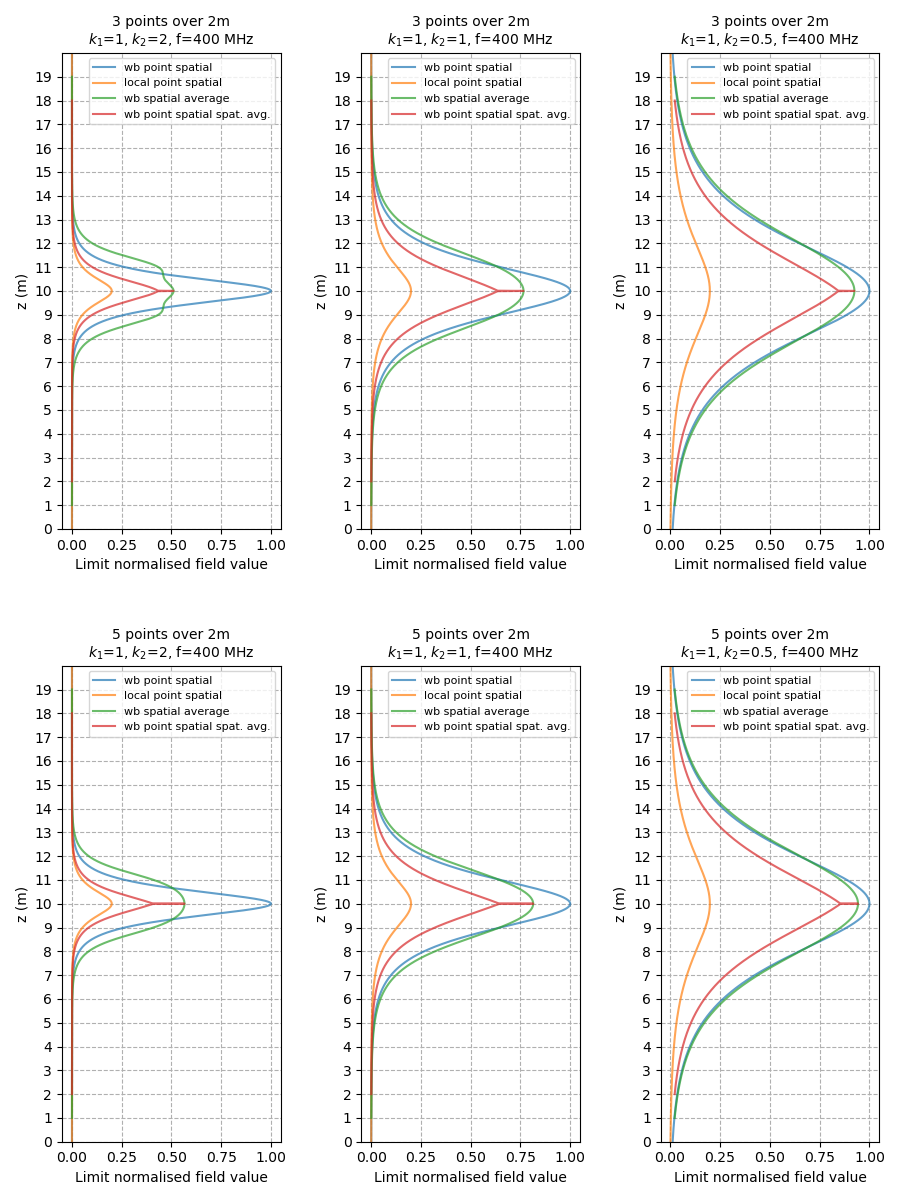

In [6]:
fig, axes = plt.subplots(2,3,figsize=(9,12))
for i, nsap in enumerate([3,5]):
    for j, k2 in enumerate([2, 1, 0.5]):
        
        # Calculate the assessments
        L = calc_ass(h=2, nsap=nsap, fMHz=400,
                     zlow=0, zhigh=20, dz=0.01,
                     k1s=1, k2s=k2,
                     zs=10)
        
        # Create the plots 
        ax = axes[i,j]
        for lass, label in zip(L.lass, L.labels):
            ax.plot(lass, L.z, alpha=0.7, label=label)
        ax.set_xlabel('Limit normalised field value')
        ax.set_ylabel('z (m)')
        ax.grid(ls='--')
        ax.legend(fontsize=8,loc='upper right')
        zmin, zmax = int(L.zlow), int(L.zhigh)
        ax.set_yticks(range(zmin,zmax))
        ax.set_ylim(zmin,zmax)
        ax.set_title(L.title,fontsize=10)
        
    fig.tight_layout(h_pad=4,w_pad=2)

# fig.savefig('../plots/nsap k2 plots 1source.png', dpi=100)        

## Vary nsap and $k_2$ for <u>two</u> sources

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
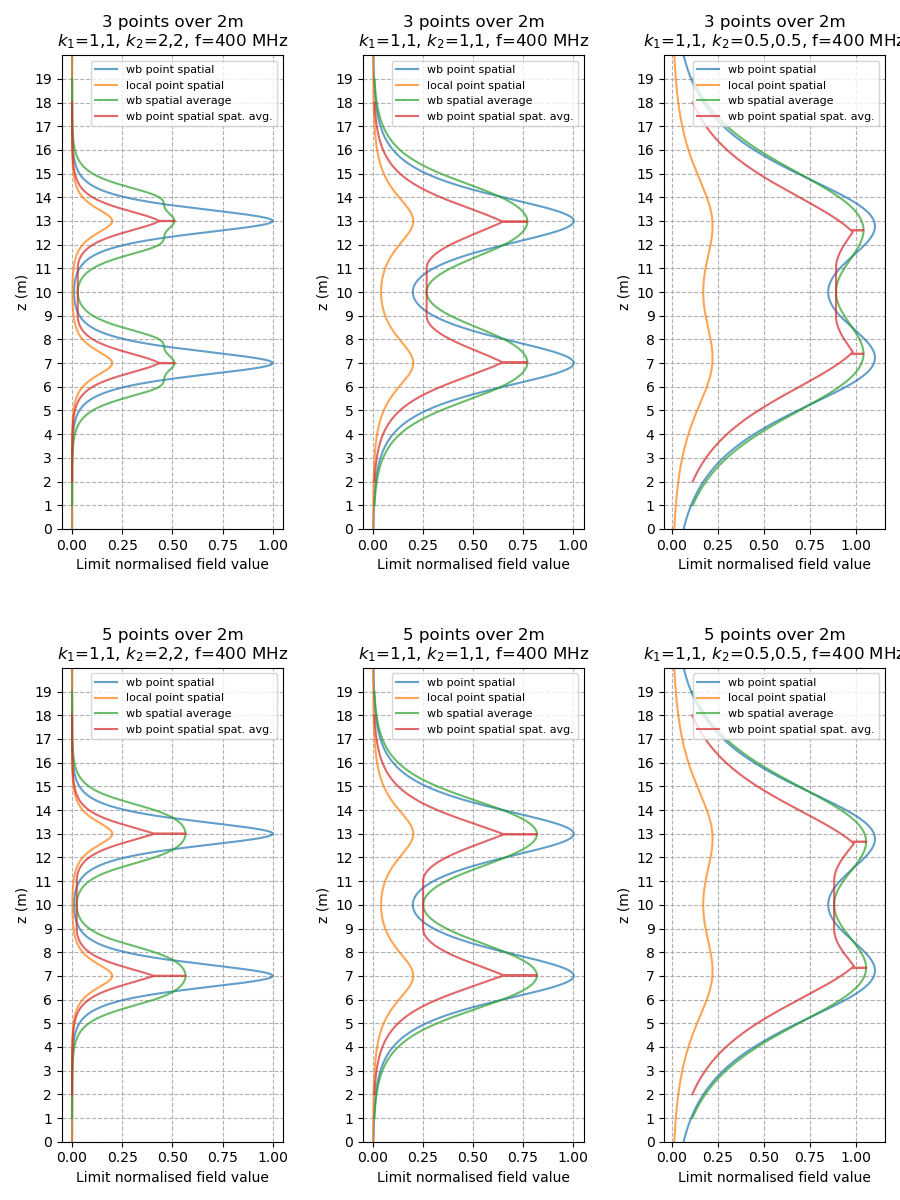

In [7]:
fig, axes = plt.subplots(2,3,figsize=(9,12))
for i, nsap in enumerate([3,5]):
    for j, k2 in enumerate([2, 1, 0.5]):

        # Calculate the assessments
        L = calc_ass(h=2, nsap=nsap, fMHz=400,
                     zlow=0, zhigh=20, dz=0.01,
                     k1s=[1]*2, k2s=[k2]*2,
                     zs=[7,13])
        
        # Create the plots
        ax = axes[i,j]
        for lass, label in zip(L.lass, L.labels):
            ax.plot(lass, L.z, alpha=0.7, label=label)
        ax.set_xlabel('Limit normalised field value')
        ax.set_ylabel('z (m)')
        ax.grid(ls='--')
        ax.legend(fontsize=8,loc='upper right')
        zmin, zmax = int(L.zlow), int(L.zhigh)
        ax.set_yticks(range(zmin,zmax))
        ax.set_ylim(zmin,zmax)
        ax.set_title(L.title)
    fig.tight_layout(h_pad=4,w_pad=2)

# fig.savefig('../plots/nsap k2 plots 2source.png', dpi=100)
    

## Scratch
*for testing out code ...*